# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2 as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Data Preparation

In [2]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_data, eval_data = train_test_split(mnist_data, train_size=0.1, random_state=42, stratify=mnist_data.targets)

# Bag-level dataset
class BagDataset(Dataset):
    def __init__(self, data, bag_size=8):
        self.data = data
        self.bag_size = bag_size

    def __len__(self):
        return len(self.data) // self.bag_size

    def __getitem__(self, idx):
        images, labels = [], []
        for i in range(self.bag_size):
            img, label = self.data[idx * self.bag_size + i]
            images.append(img)
            labels.append(label)
        bag_label = 1 if 9 in labels else 0
        return torch.stack(images), torch.tensor(bag_label)

train_dataset = BagDataset(train_data)
eval_dataset = BagDataset(eval_data)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True, num_workers=4, drop_last=True)
eval_loader = DataLoader(eval_dataset, batch_size=4, shuffle=False, pin_memory=True, num_workers=4, drop_last=True)

/home/hskha23/miniconda3/envs/tf/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


# Model Definition

## NTXentLoss

In [3]:
# Define NTXentLoss (provided by you)
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)
        z = F.normalize(z, dim=1)
        similarity_matrix = torch.mm(z, z.T) / self.temperature
        mask = torch.eye(2 * batch_size, device=z.device).bool()
        similarity_matrix.masked_fill_(mask, -float('inf'))
        exp_sim = torch.exp(similarity_matrix)
        denominator = exp_sim.sum(dim=1)
        positive_samples = torch.cat(
            [torch.arange(batch_size, 2 * batch_size), torch.arange(batch_size)], dim=0
        ).to(z.device)
        positives = similarity_matrix[torch.arange(2 * batch_size), positive_samples]
        loss = -torch.log(torch.exp(positives) / denominator)
        return loss.mean()

## Dual-Stream MIL Model (DSMIL)

In [4]:
class FCLayer(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(FCLayer, self).__init__()
        self.fc = nn.Sequential(nn.Linear(input_dim, output_dim))
        
    def forward(self, x):
        return self.fc(x)
    
class InstanceClassifier(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(InstanceClassifier, self).__init__()
        self.features_extractor = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.features_extractor.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.features_extractor.fc = nn.Identity()
        
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        batch_size, num_instances, C, H, W = x.shape
        x = x.view(batch_size * num_instances, C, H, W)
        
        instance_features = nn.Dropout(0.25)(self.features_extractor(x)).view(batch_size, num_instances, -1)
        classes = self.fc(instance_features)
        
        return instance_features, classes
    
class BagClassifier(nn.Module):
    def __init__(self, input_dim, output_dim=1, hidden_dim=128, dropout_v=0.2, non_linear=True, passing_v=False):
        super(BagClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        
        if non_linear:
            self.q = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh()
            )
        else:
            self.q = nn.Linear(input_dim, hidden_dim)
        
        if passing_v:
            self.v = nn.Sequential(
                nn.Dropout(dropout_v),
                nn.Linear(input_dim, input_dim),
                nn.ReLU()
            )
        else:
            self.v = nn.Identity()
            
        self.fc = FCLayer(input_dim, output_dim)
        
    def forward(self, features, classes):
        batch_size = features.size(0)
        num_instances = features.size(1)
        features_dim = features.size(2)
        
        combine_features = features.view(features.shape[0] * features.shape[1], -1)
        V = self.v(combine_features)
        Q = self.q(combine_features)
        assert V.shape[0] == Q.shape[0] == batch_size * num_instances, f'V: {V.shape}, Q: {Q.shape}'
        assert V.shape[1] == features_dim, f'V: {V.shape} should be [{batch_size * num_instances}, {features_dim}]'
        assert Q.shape[1] == self.hidden_dim, f'Q: {Q.shape} should be [{batch_size * num_instances}, {self.hidden_dim}]'
        
        # Get critical instance indices by squeezing classes
        critical_indices = torch.squeeze(classes).argmax(dim=1)  # Shape [32]
        assert critical_indices.shape[0] == batch_size, f'Critical indices: {critical_indices.shape}'

        # Gather features for each batch using critical instance indices
        m_features = features[torch.arange(batch_size).unsqueeze(1), critical_indices.unsqueeze(1)].squeeze()
        assert m_features.shape[0] == batch_size, f'M features: {m_features.shape} should be [{batch_size}, {features_dim}]'
        q_max = self.q(m_features)
        assert q_max.shape[0] == batch_size and q_max.shape[1] == self.hidden_dim, f'Q max: {q_max.shape} should be [{batch_size}, {self.hidden_dim}]'
        
        A = torch.mm(Q, q_max.mT)
        A = F.softmax(A / torch.sqrt(torch.tensor(Q.shape[-1]).float()), dim=0)
        assert A.shape[0] == batch_size * num_instances and A.shape[1] == batch_size, f'A: {A.shape} should be [{batch_size * num_instances}, {batch_size}]'
        
        B = torch.mm(A.T, V)
        assert B.shape[0] == batch_size and B.shape[1] == features_dim, f'B: {B.shape} should be [{batch_size}, {features_dim}]'
        
        B = B.view(1, B.shape[0], B.shape[1])
        C = self.fc(B)
        C = C.view(1, -1)
        
        return C, A, B

## Simple CNN

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))  # Max pooling layer
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3))
        self.conv_layers = nn.ModuleList([self.conv2 for _ in range(1)])
        self.fc = nn.Linear(32, 1)
        
    def forward(self, bag):
        batch_size, num_instances, c, h, w = bag.size()
        bag = bag.view(batch_size * num_instances, c, h, w)
        
        # First convolutional layer
        x = self.conv0(bag)
        x = self.pool(x)
        
        # Second convolutional layer
        x = self.conv1(x)
        x = self.pool(x)
        
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
            x = self.pool(x)
        
        # Flatten the output for the fully connected layer
        x = x.view(batch_size, num_instances, -1) # From (batch_size * num_instances, 32, 5, 5) to (batch_size, num_instances, 32 * 5 * 5)
        
        classes = self.fc(x)
        return x, classes

## Encoder Model

In [6]:
class Encoder(nn.Module):
    def __init__(self, base_model, projection_dim=128, input_dim=32):
        super(Encoder, self).__init__()
        self.encoder = base_model
        self.projection = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            # nn.Linear(512, projection_dim)
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, projection_dim)
        )
        
        self.instance_classifier = InstanceClassifier(input_dim)
        self.simple_cnn = SimpleCNN()
        self.bag_classifier = BagClassifier(input_dim)
        
    def forward(self, x):
        batch_size, num_instances, channels, height, width = x.size()
        
        # instances_features, classes = self.instance_classifier(x)
        instances_features, classes = self.simple_cnn(x)
        
        features = instances_features.view(batch_size * num_instances, -1)  # Flatten to (batch_size * num_instances, feature_dim)
        
        projection_features = self.projection(features)
        
        predicted_bags, A, B = self.bag_classifier(instances_features, classes)
        
        return projection_features, classes, predicted_bags, A, B

## Augmentation Function

In [7]:
# Version 2: Avg time taken: 0.8 seconds for 2 augmentations (w/o ResizedCrop)
def augment_batch(batch_images):
    batch_size, num_instances, channels, height, width = batch_images.shape

    # Define augmentation transformations using GPU-compatible operations
    aug_transform = transforms.Compose([
        transforms.RandomResizedCrop(28, scale=(0.75, 1.2), ratio=(0.75, 4.0/3.0)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4)], p=0.6),
        transforms.RandomGrayscale(p=0.2),
    ])

    # Apply transformations directly on the tensor without converting to PIL
    augmented_batch = torch.empty_like(batch_images)  # Preallocate memory for augmented images

    for i in range(batch_size):
        for j in range(num_instances):
            augmented_batch[i, j] = aug_transform(batch_images[i, j])

    return augmented_batch.cuda()  # Move the augmented batch to GPU

## Augmentation with Multi-scale

In [8]:
import torch
import torchvision.transforms as transforms

def augment_func_v2(batch_images):
    batch_size, num_instances, channels, height, width = batch_images.shape

    # Define augmentation transformations using GPU-compatible operations
    aug_transform = transforms.Compose([
        transforms.RandomResizedCrop(28, scale=(0.75, 1.2), ratio=(0.75, 4.0/3.0)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4)], p=0.6),
        transforms.RandomGrayscale(p=0.2),
    ])

    # Preallocate memory for augmented images
    augmented_batch = torch.empty((batch_size, num_instances * 4, channels, height, width), device=batch_images.device)

    for i in range(batch_size):
        for j in range(num_instances):
            # Apply the initial transformations
            augmented_image = aug_transform(batch_images[i, j])

            # Scale the image up to 4 times its original size
            scaled_image = torch.nn.functional.interpolate(augmented_image.unsqueeze(0), scale_factor=4, mode='bilinear', align_corners=False).squeeze(0)

            # Split the scaled image into 4 parts (assuming it is now (112, 112))
            split_images = [
                scaled_image[:, :scaled_image.shape[1] // 2, :scaled_image.shape[2] // 2],  # Top-left
                scaled_image[:, :scaled_image.shape[1] // 2, scaled_image.shape[2] // 2:],  # Top-right
                scaled_image[:, scaled_image.shape[1] // 2:, :scaled_image.shape[2] // 2],  # Bottom-left
                scaled_image[:, scaled_image.shape[1] // 2:, scaled_image.shape[2] // 2:]   # Bottom-right
            ]

            # Fill augmented_batch with split images
            for k in range(4):
                augmented_batch[i, j * 4 + k] = split_images[k]

    return augmented_batch.cuda()  # Move the augmented batch to GPU

# Model Initialization

In [9]:
# Initialize models, loss function, and optimizer
base_model = models.resnet18(weights=None)
base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
base_model.fc = nn.Identity()
encoder = Encoder(base_model).cuda()
projection_dim = 256
ntxent_loss = NTXentLoss().cuda()

# Model Training & Evaluation

In [10]:
# Training parameters
epochs = 50
learning_rate = 1e-3
optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
bceLoss = nn.BCEWithLogitsLoss()

correct_predictions = 0
total_samples = 0
# Training loop for contrastive learning
for epoch in range(epochs):
    encoder.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.cuda()  # Move the batch to GPU
        labels = labels.cuda()
        
        aug1 = augment_batch(images).cuda()
        aug2 = augment_batch(images).cuda()
        
        z_i, outputs_1, predicted_bags_1, _, _ = encoder(aug1)
        z_j, outputs_2, predicted_bags_2, _, _ = encoder(aug2)

        NTXLoss = ntxent_loss(z_i, z_j)
        max_agg_1 = torch.max(outputs_1, dim=1).values.squeeze()
        max_agg_2 = torch.max(outputs_2, dim=1).values.squeeze()

        loss_max_1 = bceLoss(max_agg_1, labels.float())
        loss_max_2 = bceLoss(max_agg_2, labels.float())
        loss_bag_1 = bceLoss(predicted_bags_1.squeeze(), labels.float())
        loss_bag_2 = bceLoss(predicted_bags_2.squeeze(), labels.float())

        loss = 0.6 * NTXLoss + 0.1 * loss_max_1 + 0.1 * loss_max_2 + 0.1 * loss_bag_1 + 0.1 * loss_bag_2
        loss = loss.mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calculate predictions and update correct predictions count
        predicted = (torch.sigmoid(predicted_bags_1.squeeze()) > 0.5).float()  # Binary classification threshold
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate average loss and accuracy for this epoch
    avg_loss = total_loss / len(train_loader)
    accuracy = (correct_predictions / total_samples) * 100  # Convert to percentage
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.5f}, Accuracy: {accuracy:.2f}%")
    
# Evaluation loop
with torch.no_grad():
    encoder.eval()
    correct, total = 0, 0
    for images, labels in eval_loader:
        images = images.cuda()
        labels = labels.cuda()
        z_i, output, predicted_bags, _, _ = encoder(images)
        predicted = (torch.sigmoid(predicted_bags.squeeze()) > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {correct/total}")

Epoch [1/50], Loss: 2.17710, Accuracy: 57.62%
Epoch [2/50], Loss: 1.89170, Accuracy: 63.24%
Epoch [3/50], Loss: 1.81706, Accuracy: 67.34%
Epoch [4/50], Loss: 1.74537, Accuracy: 71.69%
Epoch [5/50], Loss: 1.69932, Accuracy: 75.13%
Epoch [6/50], Loss: 1.66277, Accuracy: 77.90%
Epoch [7/50], Loss: 1.65003, Accuracy: 79.76%
Epoch [8/50], Loss: 1.62992, Accuracy: 81.25%
Epoch [9/50], Loss: 1.62674, Accuracy: 82.38%
Epoch [10/50], Loss: 1.61083, Accuracy: 83.41%
Epoch [11/50], Loss: 1.59195, Accuracy: 84.41%
Epoch [12/50], Loss: 1.59435, Accuracy: 85.23%
Epoch [13/50], Loss: 1.59056, Accuracy: 85.87%
Epoch [14/50], Loss: 1.58203, Accuracy: 86.47%
Epoch [15/50], Loss: 1.56781, Accuracy: 87.02%
Epoch [16/50], Loss: 1.56522, Accuracy: 87.53%
Epoch [17/50], Loss: 1.56226, Accuracy: 88.05%
Epoch [18/50], Loss: 1.55228, Accuracy: 88.50%
Epoch [19/50], Loss: 1.55506, Accuracy: 88.90%
Epoch [20/50], Loss: 1.54974, Accuracy: 89.25%
Epoch [21/50], Loss: 1.55328, Accuracy: 89.55%
Epoch [22/50], Loss: 1

# Visualizing Augmented Bags

Original batch shape: torch.Size([4, 8, 1, 28, 28])
Augmented batch shape: torch.Size([4, 8, 1, 28, 28])


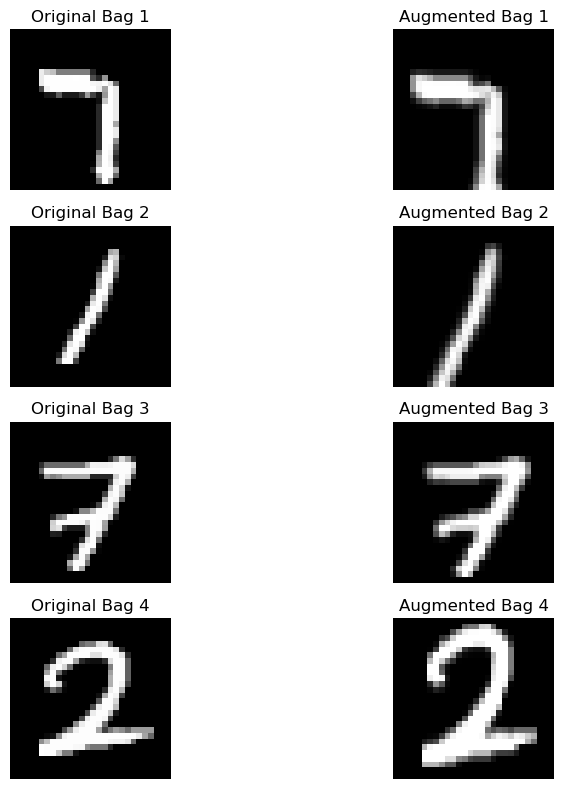

In [11]:
import matplotlib.pyplot as plt

def visualize_augmented_bags(original_bags, augmented_bags, num_bags=8):
    """
    Visualizes original and augmented bags of images.

    Parameters:
    - original_bags: A tensor of shape (batch_size, num_instances, channels, height, width)
    - augmented_bags: A tensor of shape (batch_size, num_instances, channels, height, width)
    - num_bags: Number of bags to visualize.
    """
    batch_size = original_bags.size(0)
    
    # Limit the number of bags to visualize
    num_bags = min(num_bags, batch_size)

    fig, axes = plt.subplots(num_bags, 2, figsize=(10, 2 * num_bags))
    
    for i in range(num_bags):
        # Original images
        for j in range(original_bags.size(1)):  # Iterate over instances in the bag
            img = original_bags[i][j].cpu().numpy().squeeze()  # Remove channel dimension
            axes[i, 0].imshow(img, cmap='gray')
            axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Original Bag {i + 1}')
        
        # Augmented images
        for j in range(augmented_bags.size(1)):
            img = augmented_bags[i][j].cpu().numpy().squeeze()  # Remove channel dimension
            axes[i, 1].imshow(img, cmap='gray')
            axes[i, 1].axis('off')
        axes[i, 1].set_title(f'Augmented Bag {i + 1}')

    plt.tight_layout()
    plt.show()

# Get the first batch of images from the evaluation loader
images, _ = next(iter(eval_loader))
print(f'Original batch shape: {images.shape}')

# Augment the batch of images
augmented_images = augment_batch(images)
print(f'Augmented batch shape: {augmented_images.shape}')

# Visualize the original and augmented bags
visualize_augmented_bags(images, augmented_images)